# Drug Composition Analysis - AstraZeneca

### Overview

The objective of the exercise is to fetcch data from the OpenFDA API and perform data exploration and analysis. 

### Candidate Details

**Name:** `Venkataramanan Krishnan`

**Email ID:** venkataramanan.krish@gmail.com

**Place:** Chennai

**Date :** 01-Aug-2020


## Problem Statements

### Part A:
Using the data from the OpenFDA API (documentation at https://open.fda.gov/apis/drug/label/) to determine the average number of ingredients (spl_product_data_elements) contained in AstraZeneca medicines per year.

1. Choose a method to gather the data
2. Transform the data as you see fit
3. Visualize and explore the results

The output should look similar to:

|year | drug_names | avg_number_of_ingredients|
|----|------|------|
|2018  | drugA,drugB  |  21|

### Part B:

Repeat the same analysis, calculate the average number of ingredients per year and per delivery route for all manufacturers.

The output should look similar to:

|year |  route |     avg_number_of_ingredients|
|---|----|-------|
|2018|   oral  |     123|
|2018|   injection|  213|
|2017 |  ...    |    ...|

### Part C (Optional):
Below are some questions to explore this toy problem further. 

Try creating some code if you still have time, or we can discuss some of these if you are invited for later stages of the interview:

* How would you code a model to predict the number of ingredients for next year? Note: Your predictions don't have to be good !
* Could you find the most common drug interactions for AstraZeneca medicines?
* How would you deploy your analysis/model as a tool that other users can use?



## Solution

The solution for the aforemention problems are as follows,


**Part A**
1. [Data fetch using OpenFDA API](#data_fetch)
2. [Data Preparation and Preprocessing](#data_prep)
3. [Exploratory Data Analysis](#eda)
4. [Determine Average Ingredient per year](#peryear)

**Part B**
1. [Determine Average Ingredient per year and route](#perroute)

**Part C**
1. [Model to forecast no. of ingredient for next year](#model_building)
2. [Most common drug interactions](#drug_interactions)
3. [Productionize Model as Tool](#productionize_model)


## Import Dependent Libraries

<pre>Note: Please uncomment and execute the following commands to install missing libraries.</pre>

In [1]:
# !pip install seaborn
# !pip install nltk

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [2]:
import urllib.request as request
import re
import json 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Searborn configuration
sns.set(style='whitegrid', palette='muted')

import string
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


<a id="data_fetch"></a>

## 1. Retrieve data from OpenFDA API

In [3]:
"""
Class DataRetriever-Consists method to fetch data from OpenFDA repository
    It has methods to construct the API endpoint with different query string, call the API endpoint
    convert the response JSON string data to JSON dictionary object
"""
class DataRetriever:
    # Constant variables declaration
    STARTDATE_YEAR, ENDDATE_YEAR = '0101', '1231'
    BASE_URL = "https://api.fda.gov/drug/label.json"
    QUERY_STRING = "?search=effective_time:[{0}+TO+{1}]&limit={2}"
    
    # Constructor 
    def __init__(self, year_start=2010, year_end=2020, limit=100):
        # Class variables
        self.year_range = np.arange(year_start, year_end, 1)
        self.limit = limit
        
    def pull_data(self):
        ''' this method pulls the data from REST API of OpenFDA.
            @return
                consolidated dataframe object
        '''
        whole_data = pd.DataFrame()
        
        try:
            endpoints = self.construct_endpoint()

            for endpoint in endpoints:
                # Call the API using request method
                with request.urlopen(endpoint) as res:
                    res_data = res.read()
                    json_data = json.loads(res_data)

                    yearwise_df = pd.DataFrame(json_data['results'])
                    # Append the data row-wise
                    whole_data = whole_data.append(yearwise_df, ignore_index=True)
                    
        except Exception as e:
            raise Exception("Failed to collect data :{}".format(e))
            
        return whole_data
        
    
    def construct_endpoint(self):
        ''' Method to construct endpoint url with dynamic querystring'''
        endpoints = list()
        
        for y_val in self.year_range:
            start_date = str(y_val) + self.STARTDATE_YEAR
            end_date = str(y_val) + self.ENDDATE_YEAR
            # Construct query string and append to base url
            api_endpoint = self.BASE_URL + self.QUERY_STRING.format(start_date, end_date, self.limit)
            
            endpoints.append(api_endpoint)
            
        return endpoints


In [4]:
# Initialize object for retrieve data 
# the year range is set from 2015 to 2020 with 100 records
year_start = 2015
year_end = 2020
num_records = 100

api_conn = DataRetriever(year_start, year_end, num_records)

dataset = api_conn.pull_data()

In [5]:
# View first and last few records of the dataset
dataset.head(2).append(dataset.tail(2))

,effective_time,inactive_ingredient,keep_out_of_reach_of_children,purpose,warnings,questions,spl_product_data_elements,openfda,version,dosage_and_administration,...,patient_medication_information,precautions_table,disposal_and_waste_handling,drug_abuse_and_dependence_table,instructions_for_use,use_in_specific_populations_table,pediatric_use_table,instructions_for_use_table,inactive_ingredient_table,dosage_forms_and_strengths_table
0,20151102,[INACTIVE INGREDIENTS Sucrose],[Keep this and all medication out of reach of ...,"[USES Boils, Abscess, Otitis]",[WARNINGS This product is to be used for self-...,[QUESTIONS OR COMMENTS www.Rxhomeo.com | 1.888...,[SILICEA SILICEA SILICON DIOXIDE COLLOIDAL SIL...,{},1,"[DOSAGE Adults- Take 4 or 6 Pellets by mouth, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[Keep out of reach of children If product is s...,[Purpose Sunscreen],[Warnings For external use only.],NaN,[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,{},4,[Directions Protection Naturelle SPF 46 PA+++ ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,20190401,NaN,NaN,NaN,[WARNINGS Risks from Concomitant Use with Opio...,NaN,[Clonazepam Clonazepam CLONAZEPAM CLONAZEPAM S...,{},10,[DOSAGE AND ADMINISTRATION Clonazepam is avail...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,20190228,[Inactive Ingredient purified water],"[Keep out of reach of children If swallowed, g...",[Use For Preparation of Skin prior to an injec...,"[Warnings For External Use Only Flammable, Kee...",NaN,[Dukal Sterile Alcohol Prep Pad ISOPROPYL ALCO...,"{'product_ndc': ['65517-0002'], 'is_original_p...",4,[Other Information Store at Room Temperature 1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="data_prep"></a>

## 2. Data Preparation and Preprocesing

In [6]:
# Interested columns
col_interested = ['effective_time', 'inactive_ingredient', 'spl_product_data_elements', 'active_ingredient', 'drug_interactions', 'indications_and_usage',  'openfda']

dataset[col_interested]

,effective_time,inactive_ingredient,spl_product_data_elements,active_ingredient,drug_interactions,indications_and_usage,openfda
0,20151102,[INACTIVE INGREDIENTS Sucrose],[SILICEA SILICEA SILICON DIOXIDE COLLOIDAL SIL...,[ACTIVE INGREDIENT SILICEA HPUS 2X and higher],NaN,[INDICATIONS Condition listed above or as dire...,{}
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,[BRONZE ACTIVE INGREDIENTS: TITANIUM DIOXIDE 2...,NaN,[Uses Multi-purpose mineral powder provides br...,{}
2,20151106,"[Inactive ingredients Ionized water, Carbamide]",[BAC-D Antibacterial Wound sanitizer Benzalkon...,[Active ingredient Benzalkonium chloride 0.13 %],NaN,[Uses First aid to help prevent the risk of ba...,{}
3,20150807,"[Inactive ingredients cedarleaf oil, fragrance...",[CVS Medicated Chest RubLavender scent Cough s...,[Active ingredients Camphor 4.8% Eucalyptus oi...,NaN,[Uses •temporarily relieves cough due to minor...,{}
4,20150828,[INACTIVE INGREDIENTS Sucrose/Lactose],[Iodoformum IODOFORM IODOFORM IODOFORM SUCROSE...,[ACTIVE INGREDIENTS IODOFORMUM],NaN,[INDICATIONS Indications: IODOFORMUM Cough],"{'product_ndc': ['68428-959'], 'is_original_pa..."
...,...,...,...,...,...,...,...
495,20191023,NaN,[Furadantin Nitrofurantoin NITROFURANTOIN NITR...,NaN,[DRUG INTERACTIONS Antacids containing magnesi...,[INDICATIONS & USAGE Furadantin is specificall...,{}
496,20191001,NaN,[Atorvastatin calcium Atorvastatin calcium ATO...,NaN,[7 DRUG INTERACTIONS The risk of myopathy duri...,[1 INDICATIONS AND USAGE Therapy with lipid-al...,"{'product_ndc': ['71335-1336'], 'package_ndc':..."
497,20190909,"[Inactive ingredients hypromellose, lactose mo...",[cetirizine hydrochloride Cetirizine Hydrochlo...,[Active ingredient (in each tablet) Cetirizine...,NaN,[Uses temporarily relieves these symptoms due ...,"{'product_ndc': ['62011-0414'], 'package_ndc':..."
498,20190401,NaN,[Clonazepam Clonazepam CLONAZEPAM CLONAZEPAM S...,NaN,[Drug Interactions Effect of Concomitant Use o...,[INDICATIONS AND USAGE Seizure Disorders Clona...,{}


In [7]:
dataset[col_interested].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   effective_time             500 non-null    object
 1   inactive_ingredient        289 non-null    object
 2   spl_product_data_elements  500 non-null    object
 3   active_ingredient          282 non-null    object
 4   drug_interactions          158 non-null    object
 5   indications_and_usage      486 non-null    object
 6   openfda                    500 non-null    object
dtypes: object(7)
memory usage: 27.5+ KB


### 1. Cast appropriate data type


All the attributes of the dataset is in Object type. First we need to type cast the data fields to appropriate type for further processing. 

1. effective_time field to Datetime field
2. spl_product_data_elements, active_ingredient, inactive_ingredient attributes to string type

In [8]:
def plot_null_data(dframe):
    # Figure size
    sns.set(rc={'figure.figsize':(9,8)})
    ax = sns.heatmap(dframe.isnull(), cbar=False)
    ax.set_title("Dataset columns with null values")

def cast_to_string(doc):
    if type(doc) != float:
        return str(doc[0])
    else:
        return np.nan

In [48]:
def remove_stopwords(doc):
    """
        Method to remove stopwords from the given sentence
    """
    if type(doc) == str:
        stopword_list = set(stopwords.words('english'))
        # Remove punctuations from the document string
        clean_doc = doc.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(clean_doc)
        filtered_tokens = [word for word in tokens if not word in stopword_list]
        return ' '.join(filtered_tokens)
    else:
        np.nan
        

def bigram(doc):
    """
        Splits and convert the given sentence into list of bigram tokens
    """
    filtered_sentence = remove_stopwords(doc)
    
    tokens = ngrams(filtered_sentence.split(), 2) # ngram(2-no of tokens)
    bigram_str = [token[0]+"_"+token[1] for token in tokens]
    return bigram_str

def trigram(doc):
    """
        Splits and convert the given sentence into list of trigram tokens
    """
    filtered_sentence = remove_stopwords(doc)
    tokens = ngrams(filtered_sentence.split(), 3) # ngram(3-no of tokens)
    token_set = set(token[0]+"_"+token[1]+"_"+token[2] for token in tokens)
    
#     # Filter duplicate if any
    trigram_str = ', '.join(token_set)
    
    return trigram_str


def clean_ingredient_text(doc):
    """
        The ingredient data does not have consistant delimiter to split and also have unwanted lexicals. 
        This method executed regex pattern in sequence to clean almost all unwanted words to make the ingredient more meaningful.
    """
    if type(doc) == str:
        # Remove stop words from the given sentence
        filtered_sentence = remove_stopwords(doc)
        
        pattern1 = re.compile(r'(inactive|active|ingredient|content|in each|tablet)[s]?', re.IGNORECASE)
        pattern2 = re.compile(r'\(.*\)', re.IGNORECASE)
        pattern3 = re.compile(r'\d.*(\%|\w)', re.IGNORECASE)
        pattern4 = re.compile(r'\d', re.IGNORECASE) # Clean all the numeric values
       
        # apply patterns in sequence repeatedly
        doc_str = re.sub(pattern1, '', filtered_sentence)
        doc_str = re.sub(pattern2, '', doc_str)
        doc_str = re.sub(pattern3, '', doc_str) # Making 'mg' as a marker to split the ingredient
        doc_str = re.sub(pattern4, '', doc_str)
        doc_str = re.sub(r'\s.?(mg)\s?', '-', doc_str)
        
        return doc_str
    else:
        return np.nan

def extract_route(doc):
    if not 'route' in doc.keys():
        np.nan
    else:
        return doc['route'][0]

def count_ingredient(doc):
    if type(doc) == str:
        word_list = set(word for word in doc.split('-') if len(word) > 1)
        return len(word_list)
    else:
        return 0
    
def count_inactive_ingredient(doc):
    if type(doc) == str:
        word_list = set(word for word in doc.split(' ') if len(word) > 1) # Return as a set to avoid duplicates
        return len(word_list)
    else:
        return 0

In [10]:
drug_data = dataset[col_interested]

# Type cast effective time attribute to Datetime
drug_data['effective_time'] = pd.to_datetime(drug_data['effective_time'])
drug_data['year'] = drug_data['effective_time'].dt.year

# String type fields
drug_data['spl_product_data_elements'] = drug_data['spl_product_data_elements'].apply(lambda x: str(x[0]))
drug_data['active_ingredient'] = drug_data['active_ingredient'].apply(cast_to_string)
drug_data['inactive_ingredient'] = drug_data['inactive_ingredient'].apply(cast_to_string)


### 2. Transform Drug and Ingredients data

In [11]:
print("Number of null or NAN values in Product: {} ".format(drug_data['spl_product_data_elements'].isnull().sum()))
print("Number of null or NAN values in Active Ingredients: {} ".format(drug_data['active_ingredient'].isnull().sum()))
print("Number of null or NAN values in Inactive Ingredients: {} ".format(drug_data['inactive_ingredient'].isnull().sum()))

Number of null or NAN values in Product: 0 
Number of null or NAN values in Active Ingredients: 218 
Number of null or NAN values in Inactive Ingredients: 211 


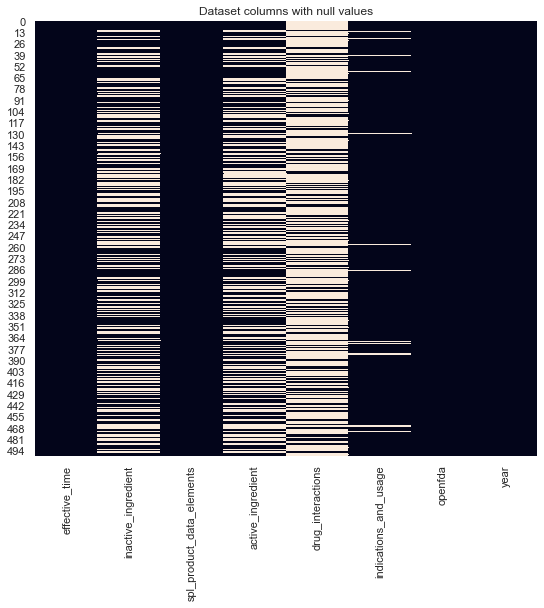

In [12]:
# View missing or NaN data in columns
plot_null_data(drug_data)

## Ingredient Attributes

There are two types of Ingredients here,
1. Active Ingredients - Ingredients who have thearapautical value in the medicine
2. Inactive Ingredients - Which do not have therapautical values in the medicine but need for production of drug as a binding agent or vector for molecules. 

To find the Average Ingredients for the year, we need to identify the unique ingredient names for product. 

### Clean and transform Ingredient fields and Route

In [49]:
drug_data['active_ingredient'] = drug_data['active_ingredient'].apply(clean_ingredient_text)
drug_data['inactive_ingredient'] = drug_data['inactive_ingredient'].apply(clean_ingredient_text)
drug_data['route'] = drug_data['openfda'].apply(extract_route)

In [50]:
drug_data['route'] = drug_data['route'].ffill().bfill() 

In [51]:
#drug_data['route'][:20].values

In [52]:
drug_data['active_ingredient'][:20].values

array(['SILICEA HPUS', 'BRONZE TITANIUM DIOXIDE', 'Benzalkonium chloride',
       'Camphor', 'IODOFORMUM', 'Purpose Octinoxate',
       'Thuja occidentalis', nan, 'Purpose Dimethicone', 'glycerine',
       'Glycerin', nan, nan, 'Ethyl Alcohol', 'Alcohol', 'Ipecacuanha',
       'Phenylephrine HCl', 'Phosphorus', nan, 'Acetaminophen'],
      dtype=object)

In [53]:
drug_data['inactive_ingredient'][:10].values

array(['Sucrose',
       'TALC POLYMETHYL METHACRYLATE VINYL DIMETHICONEMETHICONE SILSESQUIOXANE CROSSPOLYMER CALCIUM SILICATE TRIETHYLHEXANOIN ALUMINUM HYDROXIDE LAUROYL LYSINE METHICONE PHENOXYETHANOL DIMETHICONE ALUMINUM DIMYRISTATE HYDROXYAPATITIE MICA',
       'Ionized water Carbamide',
       'cedarleaf oil fragrance nutmeg oil thymol turpentine oil white petrolatum',
       'SucroseLactose',
       'WATEREAU CYCLOPENTASILOXANE GLYCERIN PROPYLENE GLYCOL CAPRYLYL METHICONE PEG',
       'Contains', nan,
       'water petrolatum mineral oil glycerin glyceryl stearate propylene glycol PEG',
       'coconut oil palm oil olive oil sodium hydroxide water lavender etc'],
      dtype=object)

In [54]:
drug_data['n_active_ingredient'] = drug_data['active_ingredient'].apply(count_ingredient)
drug_data['n_inactive_ingredient'] = drug_data['inactive_ingredient'].apply(count_inactive_ingredient)

In [55]:
#drug_data[['n_inactive_ingredient','n_ingredient']].values

In [56]:
# Adding active and inactive ingredient count to make total ingredients of the product
drug_data['n_total_ingredient'] = drug_data['n_active_ingredient'] + drug_data['n_inactive_ingredient']

In [57]:
drug_data.reset_index(drop=True, inplace=True)

In [58]:
drug_data.head()

,effective_time,inactive_ingredient,spl_product_data_elements,active_ingredient,drug_interactions,indications_and_usage,openfda,year,route,n_active_ingredient,n_inactive_ingredient,n_total_ingredient,drug_names,n_drug_count
0,2015-11-02,Sucrose,SILICEA SILICEA SILICON DIOXIDE COLLOIDAL SILI...,SILICEA HPUS,NaN,[INDICATIONS Condition listed above or as dire...,{},2015,ORAL,1,1,2,SILICEA_SILICEA_SILICON COLLOIDAL_SILICON_DIOX...,6
1,2015-01-09,TALC POLYMETHYL METHACRYLATE VINYL DIMETHICONE...,CHANTECAILLE PROTECTION NATURELLE BRONZE SPF 4...,BRONZE TITANIUM DIOXIDE,NaN,[Uses Multi-purpose mineral powder provides br...,{},2015,ORAL,1,20,21,LAUROYL_LYSINE_PHENOXYETHANOL DIOXIDE_OCTINOXA...,37
2,2015-11-06,Ionized water Carbamide,BAC-D Antibacterial Wound sanitizer Benzalkoni...,Benzalkonium chloride,NaN,[Uses First aid to help prevent the risk of ba...,{},2015,ORAL,1,3,4,sanitizer_Benzalkonium_Chloride BENZALKONIUM_W...,9
3,2015-08-07,cedarleaf oil fragrance nutmeg oil thymol turp...,CVS Medicated Chest RubLavender scent Cough su...,Camphor,NaN,[Uses •temporarily relieves cough due to minor...,{},2015,ORAL,1,8,9,Medicated_Chest_RubLavender MENTHOL_MENTHOL_PE...,20
4,2015-08-28,SucroseLactose,Iodoformum IODOFORM IODOFORM IODOFORM SUCROSE ...,IODOFORMUM,NaN,[INDICATIONS Indications: IODOFORMUM Cough],"{'product_ndc': ['68428-959'], 'is_original_pa...",2015,ORAL,1,1,2,SUCROSE_LACTOSE_white IODOFORM_IODOFORM_SUCROS...,5


## Clean and Transform SPL_PRODUCT_DATA_ELEMENT

The attribute `spl_product_data_elements` has drug or medicine names and other information. The primary constraint in this data attribute is that there is no consistent marker identify and extract the drug name. 

I have applied `Trigram` technique to extract distinct name combination from the corpus of information. It is made with the following assumptions,

**Assumption:**
1. There is will be a dictionary of drug names to lookup and compare the generated trigram.
2. The unique and meaningful drug name will be extracted from the data by using dictionary lookup and domain-specific-semantic markers. 


In [59]:
# Transform the corpus data into trigram phrase joined with '_'
drug_data['drug_names'] = drug_data['spl_product_data_elements'].apply(trigram)

In [60]:
drug_data['n_drug_count'] = drug_data['drug_names'].apply(lambda d: len(d.split(' ')))

In [61]:
drug_data['drug_names'][:2].values

array(['SILICEA_SILICEA_SILICON, COLLOIDAL_SILICON_DIOXIDE, SILICON_DIOXIDE_SUCROSE, DIOXIDE_COLLOIDAL_SILICON, SILICEA_SILICON_DIOXIDE, SILICON_DIOXIDE_COLLOIDAL',
       'LAUROYL_LYSINE_PHENOXYETHANOL, DIOXIDE_OCTINOXATE_OCTINOXATE, OCTINOXATE_ZINC_OXIDE, MICA_FERRIC_OXIDE, SPF_46_TITANIUM, LYSINE_PHENOXYETHANOL_DIMETHICONE, ZINC_OXIDE_ZINC, TITANIUM_DIOXIDE_OCTINOXATE, FERRIC_OXIDE_RED, ZINC_OXIDE_TITANIUM, ZINC_OXIDE_TALC, DIOXIDE_OCTINOXATE_ZINC, DIOXIDE_TITANIUM_DIOXIDE, DIMYRISTATE_MICA_FERRIC, PHENOXYETHANOL_DIMETHICONE_ALUMINUM, NATURELLE_BRONZE_SPF, OXIDE_TITANIUM_DIOXIDE, TRIETHYLHEXANOIN_ALUMINUM_HYDROXIDE, TITANIUM_DIOXIDE_TITANIUM, ALUMINUM_HYDROXIDE_LAUROYL, BRONZE_SPF_46, OXIDE_ZINC_OXIDE, CALCIUM_SILICATE_TRIETHYLHEXANOIN, TALC_CALCIUM_SILICATE, DIMETHICONE_ALUMINUM_DIMYRISTATE, 46_TITANIUM_DIOXIDE, OCTINOXATE_OCTINOXATE_ZINC, SILICATE_TRIETHYLHEXANOIN_ALUMINUM, ALUMINUM_DIMYRISTATE_MICA, HYDROXIDE_LAUROYL_LYSINE, OXIDE_TALC_CALCIUM, PROTECTION_NATURELLE_BRONZE, CHANTE

In [62]:
# Extract desired features
feature_cols = ['year', 'drug_names','route', 'n_total_ingredient', 'n_drug_count']

processed_df = drug_data[feature_cols]

In [63]:
processed_df.head().append(processed_df.tail())

,year,drug_names,route,n_total_ingredient,n_drug_count
0,2015,"SILICEA_SILICEA_SILICON, COLLOIDAL_SILICON_DIO...",ORAL,2,6
1,2015,"LAUROYL_LYSINE_PHENOXYETHANOL, DIOXIDE_OCTINOX...",ORAL,21,33
2,2015,"sanitizer_Benzalkonium_Chloride, BENZALKONIUM_...",ORAL,4,9
3,2015,"topical_analgesic_CAMPHOR, OIL_MENTHOL_MENTHOL...",ORAL,9,18
4,2015,"SUCROSE_LACTOSE_white, IODOFORM_IODOFORM_SUCRO...",ORAL,2,5
495,2019,"ACID_MONOHYDRATE_GLYCERIN, MONOHYDRATE_GLYCERI...",TOPICAL,0,17
496,2019,"ALCOHOL_UNSPECIFIED_TITANIUM, Atorvastatin_cal...",ORAL,0,37
497,2019,"CORN_TITANIUM_DIOXIDE, Tablets_CETIRIZINE_HYDR...",ORAL,12,26
498,2019,"1_ANHYDROUS_LACTOSE, CLONAZEPAM_CLONAZEPAM_STA...",ORAL,0,21
499,2019,"WATER_ISOPROPYL_ALCOHOL, ALCOHOL_WATER_ISOPROP...",TOPICAL,3,10


<a id="eda"></a>

## Exploratory Data Analysis


In [64]:
drug_data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,500.0,2017.000,1.415630,2015.0,2016.0,2017.0,2018.0,2019.0
n_active_ingredient,500.0,0.544,0.498559,0.0,0.0,1.0,1.0,1.0
n_inactive_ingredient,500.0,4.266,6.270717,0.0,0.0,1.0,6.0,32.0
n_total_ingredient,500.0,4.810,6.541214,0.0,0.0,2.0,7.0,33.0
n_drug_count,500.0,31.630,28.018908,2.0,15.0,26.0,38.0,245.0


### Data Aggregation

1) Find the **average number of ingredients** (spl_product_data_elements) contained in AstraZeneca medicines per year

In [65]:
avg_ingredient_per_year = processed_df.groupby('year').agg({'drug_names': ''.join, 'n_total_ingredient': 'mean'})

In [66]:
avg_ingredient_per_year['year'] = avg_ingredient_per_year.index
avg_ingredient_per_year.reset_index(level=0, drop=True, inplace=True)

In [67]:
avg_ingredient_per_year = avg_ingredient_per_year.rename({'n_total_ingredient': 'avg_number_of_ingredients'}, axis=1)

output_cols = ['year', 'drug_names', 'avg_number_of_ingredients']

avg_ingredient_per_year = avg_ingredient_per_year.reindex(columns=output_cols)
avg_ingredient_per_year['avg_number_of_ingredients'] = avg_ingredient_per_year['avg_number_of_ingredients'].apply(np.round)

<a id="peryear"></a>

**Output of Analysis 1**

In [68]:
avg_ingredient_per_year

,year,drug_names,avg_number_of_ingredients
0,2015,"SILICEA_SILICEA_SILICON, COLLOIDAL_SILICON_DIO...",6.0
1,2016,"MW_CROSPOVIDONE_TALC, 80_12_GABAPENTIN, STEARA...",4.0
2,2017,"Water_Benzalkonium_Chloride, Sodium_Hydroxide_...",4.0
3,2018,"MEZEREUM_BARK_white, DAPHNE_MEZEREUM_BARK, BAR...",6.0
4,2019,"FERRIC_OXIDE_YELLOW, OXIDE_RED_FERRIC, MAGNESI...",5.0


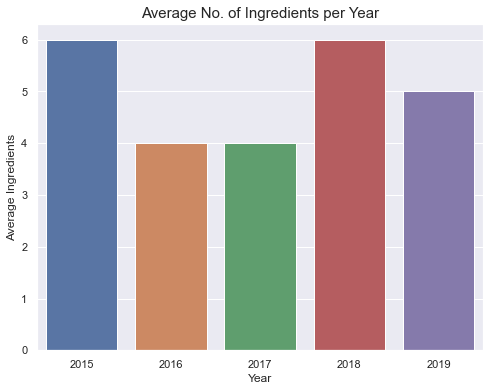

In [69]:
# Plotting year and average ingredients count
plt.figure(figsize=(8,6))
sns.barplot(x='year', y='avg_number_of_ingredients', data=avg_ingredient_per_year)
plt.title("Average No. of Ingredients per Year", fontsize=15)
plt.xlabel('Year')
plt.ylabel('Average Ingredients')
plt.show()



2) Find the **average number of ingredients** per **year** and per **delivery route** for all manufacturers.

In [70]:
avg_ingredient_per_route = processed_df.groupby(['year','route']).agg({'n_total_ingredient': 'mean'})

In [71]:
avg_ingredient_per_route = avg_ingredient_per_route.reset_index()

avg_ingredient_per_route = avg_ingredient_per_route.rename({'n_total_ingredient': 'avg_number_of_ingredients'}, axis=1)
avg_ingredient_per_route['avg_number_of_ingredients'] = avg_ingredient_per_route['avg_number_of_ingredients'].apply(np.round)

<a id="perroute"></a>

**Output of Analysis 2**

In [72]:
avg_ingredient_per_route

,year,route,avg_number_of_ingredients
0,2015,INTRAVENOUS,6.0
1,2015,ORAL,7.0
2,2015,TOPICAL,6.0
3,2016,INTRAVENOUS,1.0
4,2016,ORAL,4.0
5,2016,TOPICAL,3.0
6,2017,INTRAVENOUS,2.0
7,2017,NASAL,4.0
8,2017,OPHTHALMIC,0.0
9,2017,ORAL,4.0


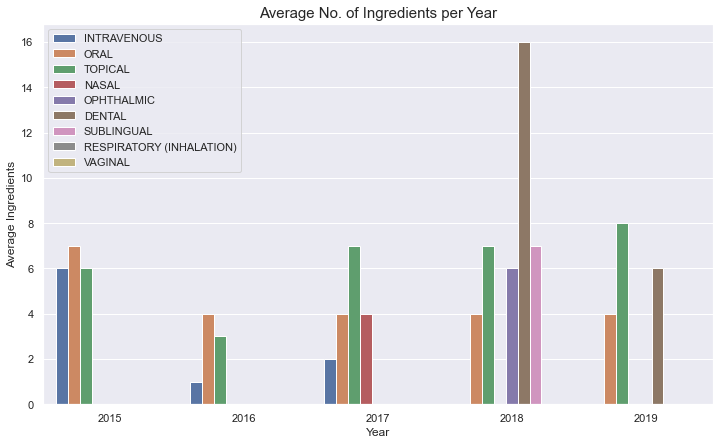

In [73]:
# Plotting year, route and average ingredients count
plt.figure(figsize=(12,7))

# plt.rcParams["legend.loc"] = 'upper right'
sns.barplot(x='year', y='avg_number_of_ingredients', hue='route', data=avg_ingredient_per_route)
plt.title("Average No. of Ingredients per Year", fontsize=15)
plt.xlabel('Year')
plt.ylabel('Average Ingredients')
plt.legend(loc='upper left')
plt.show()


<a id="model_building"></a>

## Model Building

The data here is in the form of Time Series. A model to be built to forecast the total ingredients required for next year based on the previous years utilization. 

Here we need to predict one variable for single step order. We can use any AutoRegression(AR) timeseries prediction method. When the data is huge we can used other timeseries methods such as ARMA or ARIMA. 

In [74]:
# Aggregate drug counts per year
drugs_per_year = processed_df.groupby('year').sum()

drugs_per_year = drugs_per_year.reset_index()

drugs_per_year

,year,n_total_ingredient,n_drug_count
0,2015,591,3537
1,2016,354,2956
2,2017,429,3194
3,2018,562,3144
4,2019,469,2984


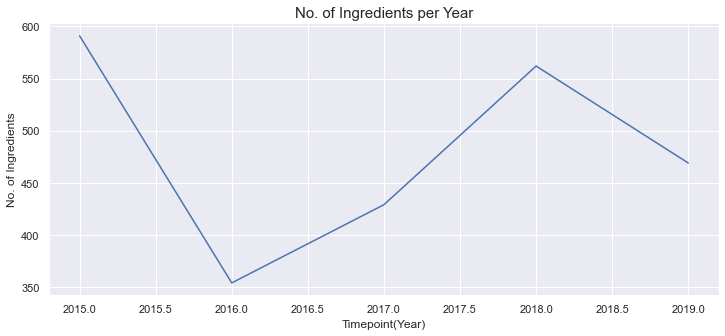

In [75]:
# sns.lineplot(x=drugs_per_year['year'], y=drugs_per_year['n_total_ingredient'] )
plt.figure(figsize=(12,5))
sns.lineplot(x="year", y="n_total_ingredient", data=drugs_per_year)
plt.title("No. of Ingredients per Year", fontsize=15)
plt.xlabel("Timepoint(Year)")
plt.ylabel("No. of Ingredients")
plt.show()

## AutoRegression Model

In [76]:
from statsmodels.tsa.ar_model import AutoReg

ingredients = drugs_per_year['n_total_ingredient']

# Autoregression model, with trend=constant
ar_model = AutoReg(ingredients, lags=1).fit()

ar_model.params

intercept                611.396311
n_total_ingredient.L1     -0.326232
dtype: float64

In [77]:
# make prediction
next_ingredient = ar_model.predict(len(ingredients), len(ingredients))

In [78]:
print("No of ingredients required for the year 2020 is: {}".format(round(next_ingredient.values[0])))

No of ingredients required for the year 2020 is: 458.0


<a id="drug_interactions"></a>

## Common Drug Interactions

A drug interaction is a reaction between two (or more) drugs or between a drug and a food, beverage, or supplement.

The dataset has an attribute called `Drug Interaction`, which contains text information. 

In [79]:
drug_data['drug_interactions'].iloc[11]

['Drug Interactions Psychotropic Agents MAO Inhibitors: It is recommended that buspirone hydrocloride not be used concomitantly with MAO inhibitors (see WARNINGS section). Amitriptyline: After addition of buspirone to the amitriptyline dose regimen, no statistically significant differences in the steady-state pharmacokinetic parameters (C max, AUC, and C min) of amitriptyline or its metabolite nortriptyline were observed. Diazepam: After addition of buspirone to the diazepam dose regimen, no statistically significant differences in the steady-state pharmacokinetic parameters (C max, AUC, and C min) were observed for diazepam, but increases of about 15% were seen for nordiazepam, and minor adverse clinical effects (dizziness, headache, and nausea) were observed. Haloperidol: In a study in normal volunteers, concomitant administration of buspirone and haloperidol resulted in increased serum haloperidol concentrations. The clinical significance of this finding is not clear. Nefazodone: [S

### Solution Approach 

The drug interaction is specified in a verbose manner. The conventional method on text extraction using regular expression can be applied, but the outcome may not be consistent when the new pattern of text appears. 

The effective approach would be `Clustering`, we can perform clustering on the drug interaction data to find the common terms. The preprocessing steps for clustering like 
* Bigram or Trigram, 
* BOW vectors, 
* TFIDF vector, 
* Dimensionality reduction(either TruncatedSVD or T-SNE) 

can be performed before applying cluster algorithm. We can find the common drug interaction by the cluster that includes more number of documents. 

Alternatively we can also do `Topic Modeling`. Topic modeling will give us keyterms and label for the group of documents. We extract the sentence from text corpus and perform preprocessing operations follwed by applying *LDA(Latent Dirichlet Analysis)* algorithm. 


<a id='productionize_model'></a>

## Productionize Model

The analysis/model can be made available to other users by either making it an interactive system or software component for an existing system. 

In general, the process of productionize model will consist of four to five step starting from notebook setup to deploy container. Basically a model is expected to have APIs whether it will be integrated to a system or accessed independently. This will make the model decoupled with system when it gets integrated. 

The following steps describe on building a model and make it available for others to use:

1. <span style="color:blue;font-weight:600;" >Setup Notebook</span>:

       Exploring dataset, preparing data and building model requires lot of trail and error activities to be perform. Jupyter notebook is the best approach for this step as it provides Interactive Computing Environment which reduces lot of development time. 
    * <span style="color:red;" >Setup jupyter notebook</span>- for data preparation, analysis and model building
    * <span style="color:red;" >Train model</span> - the algorithm will be trained with train, validation dataset. The model can be saved on desk using serialization library(pickle, joblib etc)
    
2. <span style="color:blue;font-weight:600;" >Django Model</span>:
        
    * <span style="color:red;" >Build Django Model</span> - We need to create Django app along with refactored data preparation and model building code.
    * <span style="color:red;" >Django REST API</span> - We need to build APIs for the model. Minimum 2 APIs may require for training and prediction purpose. 
    
3. <span style="color:blue;font-weight:600;" >Web Interfaces</span>:
        
    * <span style="color:red;" >Web UI</span> - Based on the requirements, we can build a view for model training and prediction. Furthermore, we can also provide UI provision to change and alter model parameters for optimization. 
4. <span style="color:blue;font-weight:600;" >A/B Testing</span>:
    * <span style="color:red;" >A/B Testing for different algorithms</span> - When more than one algorithms are used for the same dataset and to decide which one performs better we will do A/B testing with few customer to the performance of different implemented ML algorithms. The metrics of the algorithms will be captured for evaluation. The best performed algorithm will be moved to PRODUCTION environment. 
5. <span style="color:blue;font-weight:600;" >Deployment</span>:
     * <span style="color:red;" >Container based deployment:</span> - Deploying model code with docker will make things easy to deploy any infrastructure and scale the service on the need basis. 
     * <span style="color:red;" >Non-container deployment:</span> - We need to prepare Django web API and module for production ready with change in configurations. We can deploy it in gunicorn+nginx or anyother wsgi supported web server. 

### Thank you!